## Initial Condition Prediction

In this notebook, we look at learning a new encoder to map from the learned gaussian latent space to the final curve reconstruction using solely the initial conditions of a given curve. We will demonstrate this here for 2D datasets first. 

We begin by importing all the necessary dependencies. 

In [1]:
# We begin by importing the essentials
import numpy as np
import matplotlib.pyplot as plt

# We also setup torch for later usage.
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange
from torch.nn import functional as F

from sklearn.model_selection import train_test_split 

# Configure GPU if available
if torch.cuda.is_available():
    # device = "cuda:0"
    
    device = "cuda:0"
else:
    device = "cpu"

display(device)

'cuda:0'

### Import Datasets

Now we dedicate the next few blocks of code of setting up our dataset. Our aim is to used our trained VAE model in conjunction with a new MLP encoder newtork to map the initial conditions of a system to a full trajectory. We will here use the same dataset used to generate the limit cycle used in the initial figure, but a dataset can be easily be substituted by modifying the `file_name` variable and supplying an appropriate VAE decoder trained on that dataset. 

(4218, 2, 30)
(1407, 2, 30)


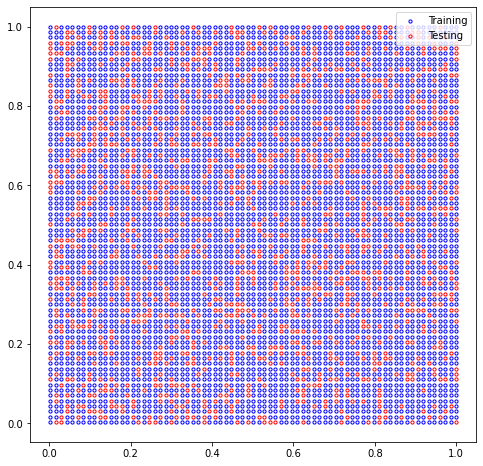

In [2]:
file_name = "./saved_sims/fig_lc.npy"
X = np.load(file_name)

# Now we split again into our previous train/test partitions
X = (X - X.min())/(X.max() - X.min())

# We now extract the initial conditions
I = X[:, :, 0]

X_train, X_test, I_train, I_test = train_test_split(X,I,  test_size = 0.25, random_state = 42)
print(X_train.shape)
print(X_test.shape)

# We now plot the training and testing initial conditions in order to show the datasplit
plt.figure(figsize = (8,8))
plt.scatter(I_train[:,0], I_train[:,1], color = "w", edgecolor = "b", s = 10,  label = "Training")
plt.scatter(I_test[:,0],  I_test[:,1],  color = "w", edgecolor = "r", s = 10 , label = "Testing")
plt.legend()
plt.show()

Now, we have to build a dataset object to hold the training curve in order to compute L2 regrssion problem. 

In [3]:
class IVCurveDataSet(torch.utils.data.Dataset):
    
    def __init__(self, ivs, curves):
        
        self.X = ivs
        self.Y = curves
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        
        return self.X[idx, :], self.Y[idx, :, :]

Transfer to tensors and GPU as needed. 

In [4]:
print(X_train.shape)
print(I_train.shape)
X_train = torch.Tensor(X_train).double().to(device)
I_train = torch.Tensor(I_train).double().to(device)
data_loader = DataLoader( IVCurveDataSet(I_train, X_train), batch_size = 4800)

(4218, 2, 30)
(4218, 2)


## Create New Encoder Model

Now, we will build a new encoder model which will map into the latent space of our previous model. 

In [5]:
import torch
import torch.nn
from torch.nn import functional as F

class EncoderMap(torch.nn.Module):
    
    def __init__(self, base_model, B, C, L):
        super().__init__()
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2,10),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(10,10),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(10,10),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(10, hp["embedding_dimension"])
        )
        
        self.linear2 = base_model.linear2.eval()
        self.decoder = base_model.decoder.eval()
    
                
        # Get the dimensionf othe precode
        self.B = B
        self.C = C
        self.L = L
        
    def forward(self, X, ):
        
        B = X.shape[0]
        code = self.mlp(X)
        post_code = self.linear2(code)
        post_code = post_code.view(B,C,L)
        X_hat = self.decoder(post_code)
        
        return X_hat

Now we reload in a previously trained VAE model to utilize the decoder network. This VAE was previously trained on the limit cycle dataset, here we just import the fully trained model for use. 

In [6]:
trained_model = torch.load("./saved_params/fig_lc_model.pt")
X = torch.Tensor(X).to(device).double()

# Now setup the system
hp = {}

In [7]:
# Pull off the dimensionality of the system for usage in setting hyperparameters. 
pre_code = trained_model.encoder(X)
B, C, L = pre_code.shape
hp["epochs"] = 5000
hp["embedding_dimension"] = 2
hp["lr"] = 1e-3
hp["weight_decay"] = 0
hp["gamma"] = 10

In [8]:
# Create model 
mlp_decoder = EncoderMap(trained_model,B, C, L ).to(device).double()

Now we define our training function and compute. 

In [9]:
# from torch.optim.lr_scheduler import StepLR
def train_mlp_decoder(model, hp, data_loader, debug = False):

    
    # Store the losses per epoch
    running_losses = []
    decoder_norms = []
    encoder_norms = []
    
    # Configure optimizer and scheduler.
    optimizer = torch.optim.Adam(model.mlp.parameters(), lr=hp["lr"], weight_decay= hp["weight_decay"])
    # scheduler = StepLR(optimizer, step_size = 1500, gamma = 0.1)
    
    # Outerloop will iterate through epochs. tqdm function trange provides progressbar
    for i in trange(hp["epochs"]):
        
        
        epoch_loss = 0 
        # Inner loop iterates through batches
        for iv, curves in data_loader:

            # Transfer the batch to the GPU
            iv = iv.to(device)
            curves = curves.to(device)

            if debug:
                print("BATCH SHAPE: ")
                print(batch.shape)

            # Zero gradient
            optimizer.zero_grad()

            # Perform forward pass

            recons = model(iv)

            # Uncomment to verify model prediction shape
            if debug:
                print("PREDI SHAPE: ")
                print(batch.shape)

            # Compute reconstruction loss
            batch_loss = F.mse_loss(recons, curves)
            
            if debug:
                print(batch_loss)

            # Compute gradient
            batch_loss.backward()

            # Take step
            optimizer.step()

            # Append to running epoch loss
            epoch_loss += batch_loss.item()

        # Keep running track of losses
        if i % 1000 == 0:
            print(f"Epoch [{i}]: " + str(epoch_loss))
            
            decoder_norm = 0
            for layer in model.decoder:
                if hasattr(layer, "weight"):
                    decoder_norm += layer.weight.norm()
            decoder_norms.append(decoder_norm)
            
            print("DECODER WEIGHTS: ", decoder_norm.item())
    
        running_losses.append(epoch_loss)

    return model, running_losses, decoder_norms

In [10]:
trained_mlp_decoder , running_losses, decoder_norms = train_mlp_decoder(mlp_decoder, hp, data_loader)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch [0]: 0.04655573597599208
DECODER WEIGHTS:  14.98256429067507
Epoch [1000]: 0.0005070050919151439
DECODER WEIGHTS:  14.98256429067507
Epoch [2000]: 0.00025300732350012716
DECODER WEIGHTS:  14.98256429067507
Epoch [3000]: 0.00014084781925867697
DECODER WEIGHTS:  14.98256429067507
Epoch [4000]: 0.00012251494506911287
DECODER WEIGHTS:  14.98256429067507


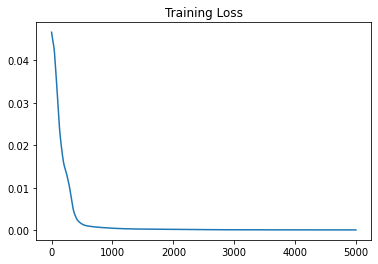

In [11]:
plt.plot(running_losses)
plt.title("Training Loss")
plt.show()

## Analyze Performance

We now look at training and testing performance on these trained models by visualizing the training and testing datasets analogously to what we were doing before. 

In [12]:
# First generate the ouput dataset
predict = trained_mlp_decoder(I_train)
predict = predict.detach()
predict.shape

torch.Size([4218, 2, 30])

In [13]:
# Pick a subset to plot
np.random.seed(10)
selected = np.random.randint(predict.shape[0],  size = 100, )
selected.shape

(100,)

<ipython-input-14-5d3d1f57c4dc>:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  plt.scatter(I_train[selected, 0].cpu().T, I_train[selected, 1].cpu().T,  c = "w", edgecolor = "b")


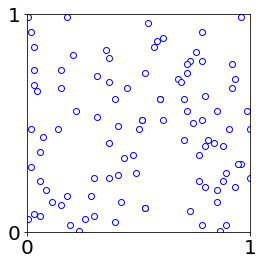

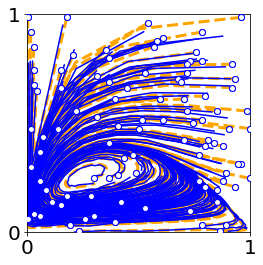

In [14]:
# First plot the training data ground truth and the predicted value

plt.figure(figsize = (4,4))
plt.scatter(I_train[selected, 0].cpu().T, I_train[selected, 1].cpu().T,  c = "w", edgecolor = "b")
plt.locator_params(axis='x', nbins=1)
plt.locator_params(axis= 'y', nbins=1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(0,1.0)
plt.ylim(0,1.0)
plt.show()

plt.figure(figsize = (4,4))
plt.plot(X_train[selected, 0].cpu().T, X_train[selected, 1].cpu().T, c = "orange", linestyle = "dashed", lw = 3)

plt.scatter(I_train[selected, 0].cpu().T, I_train[selected, 1].cpu().T,  c = "w", edgecolor = "b", zorder = 3)
plt.locator_params(axis='x', nbins=1)
plt.locator_params(axis= 'y', nbins=1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(0,1.0)
plt.ylim(0,1.0)

plt.plot(predict[selected, 0].cpu().T, predict[selected, 1].cpu().T, c = "b" )
plt.scatter(I_train[selected, 0].cpu().T, I_train[selected, 1].cpu().T,  c = "w", edgecolor = "b", zorder = 3)
plt.locator_params(axis='x', nbins=1)
plt.locator_params(axis= 'y', nbins=1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(0,1.0)
plt.ylim(0,1.0)
plt.show()

We can similarly analyze the prediction performance on the testing dataset:

In [15]:
# First generate the ouput testing dataset
trained_mlp_decoder = trained_mlp_decoder.double()
I_test = torch.Tensor(I_test).double().to(device)
predict = trained_mlp_decoder(I_test)
predict = predict.detach()

np.random.seed(42)
selected = np.random.randint(predict.shape[0],  size = 300, )
selected.shape

(300,)

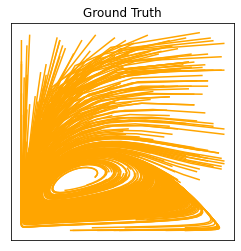

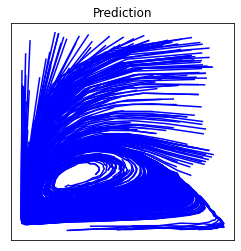

In [16]:
# Now for testing data
plt.figure(figsize = (4,4))

plt.title("Ground Truth")
plt.plot(X_test[selected, 0].T, X_test[selected, 1].T, c = "orange",)
plt.locator_params(axis='x', nbins=1)
plt.locator_params(axis= 'y', nbins=1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize = (4,4))

plt.title("Prediction")
plt.plot(predict[selected, 0].cpu().T, predict[selected, 1].cpu().T, c = "b" )
plt.locator_params(axis='x', nbins=1)
plt.locator_params(axis= 'y', nbins=1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks([])
plt.yticks([])
plt.show()

We can visualize individual communites as well as the whole phase space:

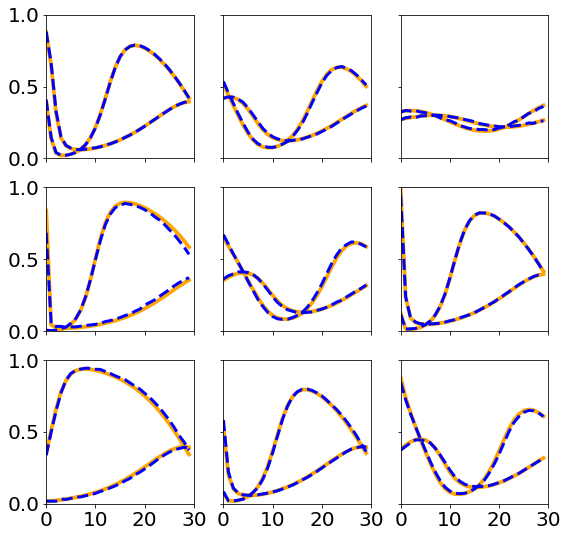

In [17]:
fig, axs = plt.subplots(3,3, figsize = (9,9), sharex = True, sharey = True)
axs = axs.flatten()

i = 0
for ax in axs:
    
    ax.locator_params(axis='x', nbins=3)
    ax.locator_params(axis= 'y', nbins=3)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlim(0,30.0)
    ax.set_ylim(0,1.0)

    rand = np.random.randint(X_test.shape[0])
    ax.plot(X_test[rand,:,:].T,  c = "orange", lw = 3.8)
    ax.plot(predict[rand,:,:].T.cpu(), c = "blue", linestyle = "--" ,lw = 3,  )
    i += 1

Lastly, we can measure the overall performance of the regression by plotting the observed vs predicted values and calculate the $R^2$ coefficient. 

0.9980058964681924


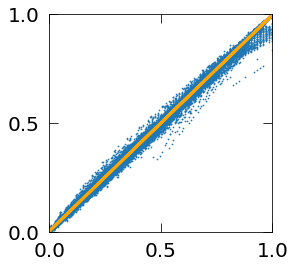

In [18]:
from scipy import stats

predict = predict.cpu().flatten()

plt.figure(figsize = (4,4))


plt.tick_params(
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,  
    left = True,
    right = True, # ticks along the top edge are off
    labelbottom=True,
        labelleft = True,
        zorder = 10,
        length = 9,
        labelsize = 20,
        direction = "in",
        pad = 10, 
    ) # labels 

plt.locator_params(axis='x', nbins=3)
plt.locator_params(axis='y', nbins=3)


X_test_string = X_test.flatten()
predict_string = predict.flatten()

plt.xlim(0,1)
plt.ylim(0,1.0)

slope, intercept, r_value, p_value, std_err = stats.linregress(X_test_string, predict_string)

plt.scatter(X_test_string, predict_string, s = 0.5, alpha = 1)
plt.plot(X_test_string, slope*X_test_string+ intercept, c = "orange", lw = 3)
print(r_value**2)
plt.show()